## Non linear effects in stimuli composed of two tones of the same amplitude

In measurements of characteristic frequency with two tones strategy (CF2T), some non linear phenomena appear. First part of this code is devoted to describe how to measure the vector strength in the synchronic representation, and the second part explain the CF2T experiment that utilizes such magnitud.  


In [1]:
%matplotlib widget

import synchrony as sync

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import patches
import numpy as np
from scipy import stats as sps 
import numpy.fft as ft
from scipy import signal as sig
from scipy import io
import scipy.io.wavfile as wav
#from scipy.linalg import toeplitz
from math import *
from random import randrange, uniform

from threading import Event


%load_ext autoreload
%autoreload 2

In [2]:
# Filter order
N = 2048
# Sampling frequency
Fs = 16000
fz = 2000.
df = 50./log(sqrt(2))
# fp_minus_fz = 10.*np.log(2.)/np.log(np.sqrt(2.))
fp_minus_fz = .1*np.log(2.)/np.log(np.sqrt(2.))
print('Cutoff freq fz = {}'.format(fz))
print('Peak frequency distance to cutoff = {}'.format(fp_minus_fz))
print('Band width = {}'.format(df))
#Discrete time filter impulsive response:
hn = sync.hn_cochlear(N,Fs,df,fz,fp_minus_fz)
Ncont = 2**14
# Filter freq. response
om_c = np.linspace(0,Fs,Ncont,endpoint=False)*2*np.pi
H_v2 = np.fft.fft(hn, Ncont)
fplot = om_c[::4]/(2*np.pi)
H_plot = H_v2[::4]
        


# One second of input signal
ltime = int(Fs)
y = np.empty((1,ltime))
t = np.linspace(0,ltime/Fs,ltime,endpoint=False)



Cutoff freq fz = 2000.0
Peak frequency distance to cutoff = 0.19999999999999996
Band width = 144.26950408889633


### Vector strength

#### Introduction explanation
This measurements uses several concepts already applied in the previous experiment. The new concept is vector strength which is explained first, as it is needed in the final CF2T experiment.

Importan internal signals in the synchronic representation in this case are:

* Filter output to each tone stimulus.
* PLL signals: 
    - Estimated frequency
    - VCO signal.

In order to measure the vector strength, another signal is derived from the VCO, interpreted as the spike produced by the cell. It corresponds to one delta at the beggining of each VCO cicle.

Vector strengh is defined in:

J. M. Goldberg and P. B. Brown. Response of binaural neurons of dog superior olivary complex to dichotic tonal stimuli: some physiological mechanisms of sound localization. *Journal of Neurophysiology*, 32:613–636, 1969.

Quoting some parts: 

"Synchronizing or phase-locking of the discharge of the auditory neurons to low frequency sine waves... bears some comment. Each spike can ... be considered as defining a vector of unit length with a phase angle $\theta_i$, $\theta \leq \theta_i \leq 2\pi$, the $x_i$ and $y_i$ componentes being: 

$$ x_i = \cos(\theta_i),
y_i = \sin(\theta_i)$$

The $n$ vectors characterizing a spike train are treated as a distribution on a unit circle. The length of the mean vector calculated as 

$$ 
r = \frac{\sqrt{ \left(\sum x_i\right)^2 + \left(\sum y_i\right)^2}}{n}
$$

provides a measure of the degree of phase-locking or synchronization. The parameter $r$ called the `vector strengh` may vary between 1 and 0, being 1 and indication of perfect synchronization."

From this definition, we adapt the calculation as mentioned by other authors, as the absolute magnitude of the Fourier Series of the discrete spikes signals evaluated at the desired frequency, divided by the square root of the total signal energy. In this implementations, DFT (Discrete Fourier Transform) is used to compute the Fourier Series by using a great number of points to sample adequately the frequency axes. 


##### Example of vector strength in a pure tone and two tone stimuli
These two cases display previous described signals and computation

/home/ppelle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


<IPython.core.display.Javascript object>


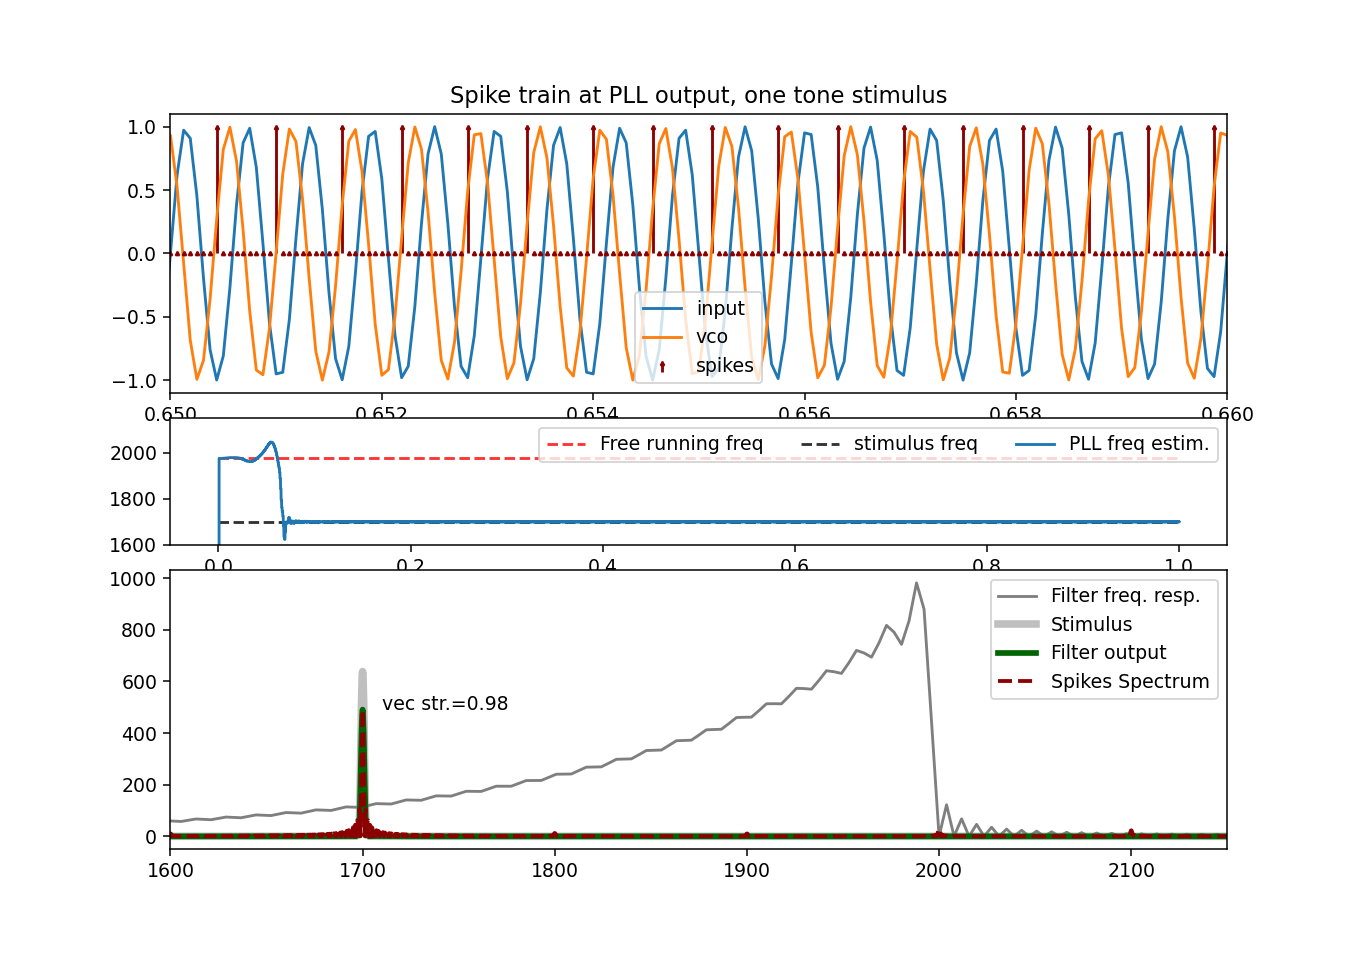

Text(0.5, 1.0, 'Spike train at PLL output, one tone stimulus')

In [6]:
# Single tone stimulus:
A = 1
f1 = 1700.
x1 = A * np.sin(2*pi*f1*t)

# Synchronic computation, filter and PLL as before.
y1 = sig.lfilter(hn,[1.],x1)
y[0,:] = y1 
pll = sync.bank_pll(nplls = 1, ltime=ltime, sita=0.7, Fn=200., Fo=1975, fc_lock=4,Fs=Fs)
pll.section_calc(y)
# spikes train computation
pos = np.sign(pll.vco90[0,:])
# pos = np.sign(x1)
tmp = sig.lfilter([0.5, -0.5],[1.],pos)
deltas = tmp*(np.sign(tmp)+1)/2.

#DFTs: only last one is necessary to compute vector strength; the others are for illustration purposes.
In = np.fft.fft(x1*np.hanning(len(x1)),8*len(deltas[t>=0.1]))
Out = np.fft.fft(y[0,:]*np.hanning(y.shape[1]),8*len(deltas[t>=0.1]))
Del = np.fft.fft(deltas[t>=0.1],8*len(deltas[t>=0.1]))


F = np.linspace(0,Fs,8*len(deltas[t>=0.1]),endpoint=False)

Mi = np.max(np.abs(In))
Mo = np.max(np.abs(Out))
MH = np.max(np.abs(H_plot))
Md = np.max(np.abs(Del[(F>=(f1-1.)) & (F<=(f1+1))]))
NN = (deltas[t>=0.1]**2).sum()

fig = plt.subplots(figsize=(10,7))
gridsize = (5,1)
ax0 = plt.subplot2grid(gridsize, (0, 0), colspan=1, rowspan=2)
ax1 = plt.subplot2grid(gridsize, (2, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid(gridsize, (3, 0), colspan=1, rowspan=2)


ax0.plot(t,1/A*x1)
ax0.plot(t,pll.vco90[0,:])
markerline,s,b = ax0.stem(t,deltas,linefmt ='darkred',basefmt='none',\
                      use_line_collection=True)
plt.setp(markerline,marker='^',color='darkred',markersize=2,alpha=1)

ax1.plot([t[0],t[-1]],[1975]*2,color='r',ls='--', alpha=0.8,label='Free running freq')
ax1.plot([t[0],t[-1]],[f1]*2,color='k',ls='--', alpha=0.8,label='stimulus freq')
ax1.plot(t,pll.freq[0,:],label='PLL freq estim.')

# ax2.plot(t,pll.lock[0,:])
ax2.plot(fplot[(fplot>=1400) & (fplot<=2200)],np.abs(H_plot[(fplot>1400) & (fplot<=2200)])/MH*Mo*2.,\
    'k',alpha=0.5,label='Filter freq. resp.')
ax2.plot(F,np.abs(In)/Mi*Mo*1.3,lw = 4.,color=[0.5]*3,label='Stimulus',alpha=0.5)
ax2.plot(F,np.abs(Out),lw = 3.,color='darkgreen',label='Filter output')
ax2.plot(F,np.abs(Del)/Md*Mo,'--',lw = 2.,color='darkred',label='Spikes Spectrum')
tt = ax2.text(f1+10,Mo,'vec str.={:1.2f}'.format(Md/NN))
plt.setp(tt,ha='left')
ax0.set_xlim(65*0.01,66*0.01)
ax1.set_ylim(1600,2150)
ax2.set_xlim(1600,2150)
ax0.legend(('input','vco','spikes'))
ax1.legend(loc='upper right',ncol=3)
ax2.legend()
ax0.set_title('Spike train at PLL output, one tone stimulus')

In this case in the upper graph input signal, VCO signal an spikes are shown. The following graph corresponds to the frequency estimation at the PLL output. The third graph is showing the stimulus, filter output and spikes spectra. Filter frequency response is displayed also as a reference.

It should be stress that due to the intrinsic discrete nature of these signals, spikes has several displacements from a continuos version calculation. As an example, in the following figure a spike train is generated from the stimulus tone directly showing that many undesired harmonics may appear, one of them present at 2000 Hz, as displayed also at the bottom graph in the previous figure.  

<IPython.core.display.Javascript object>


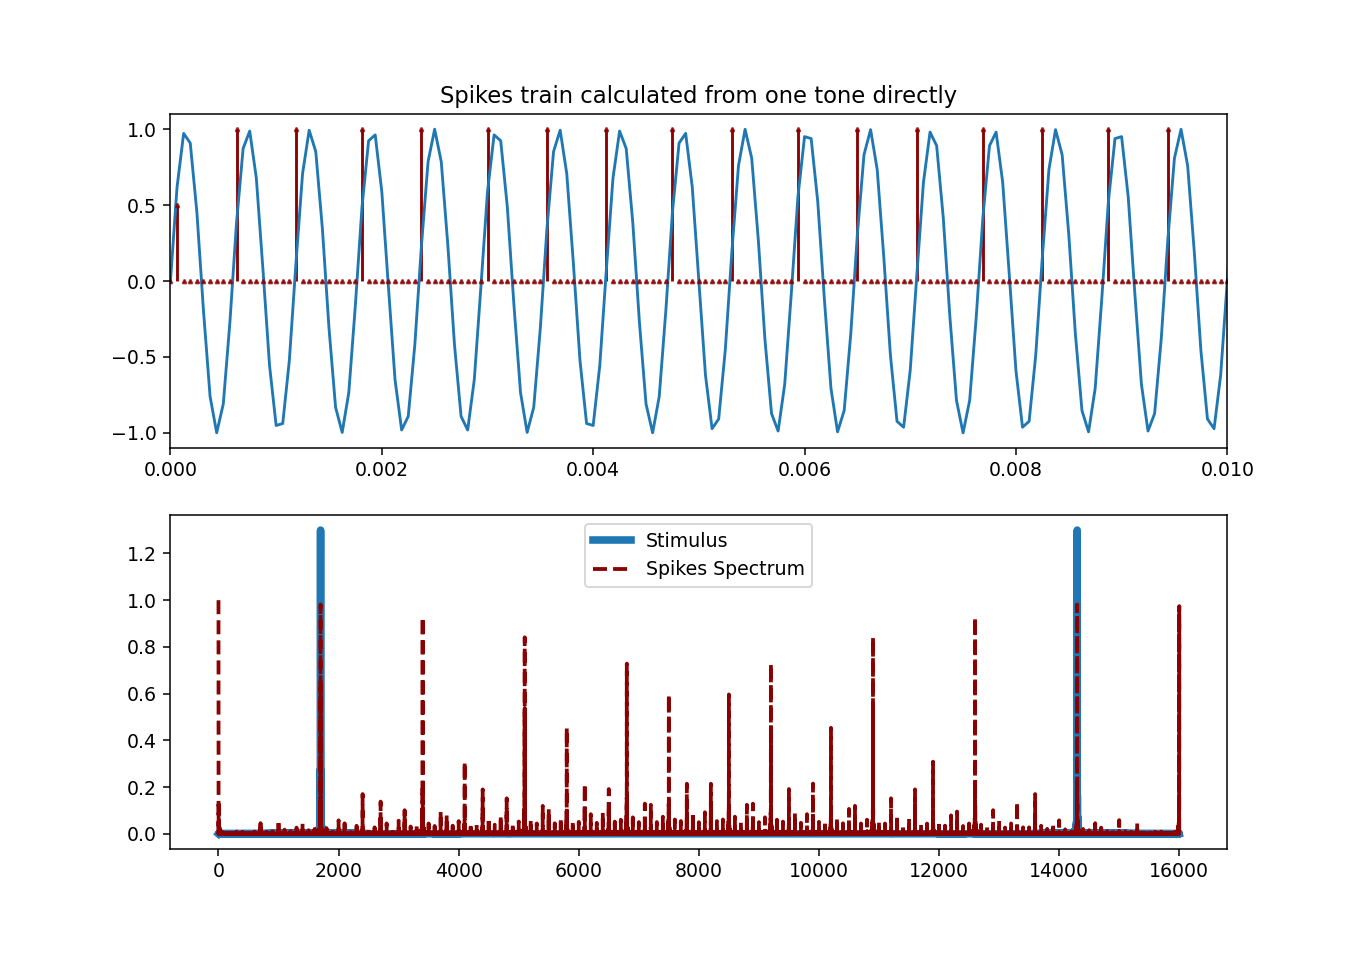

Discrete Vector strength = 1.0


In [7]:
pos = np.sign(x1)
tmp = sig.lfilter([0.5, -0.5],[1.],pos)
deltas = tmp*(np.sign(tmp)+1)/2.

In = np.fft.fft(x1[t>=0.1],8*len(deltas[t>=0.1]))
Del = np.fft.fft(deltas[t>=0.1],8*len(deltas[t>=0.1]))
Mi = np.max(np.abs(In))
Md = np.max(np.abs(Del))
NN = (deltas[t>=0.1]**2).sum()

fig, ax = plt.subplots(2,1,figsize=(10,7))
ax[0].plot(t,x1)
markerline,s,b = ax[0].stem(t,deltas,linefmt ='darkred',basefmt='none',\
                      use_line_collection=True)
plt.setp(markerline,marker='^',color='darkred',markersize=2,alpha=0.8)
ax[0].set_xlim(0.,0.01)
ax[1].plot(F,np.abs(In)/Mi*1.3,lw = 4.,color='C0',label='Stimulus',alpha=1)
ax[1].plot(F,np.abs(Del)/Md,'--',lw = 2.,color='darkred',label='Spikes Spectrum')
ax[1].legend()
ax[0].set_title('Spikes train calculated from one tone directly')
print('Discrete Vector strength = {}'.format(Md/NN))

In this case the vector strength is 1, showing a perfect sinusoidal input. Compared to the previous case (0.98) we can infer that in the case a pure tone stimulus, synchronic representation is quasi perfectly synchronized, as expected.

In the following case, two simultaneous tones are presented, and both vector strengths are calculated over PLL output.

/home/ppelle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  # This is added back by InteractiveShellApp.init_path()


<IPython.core.display.Javascript object>


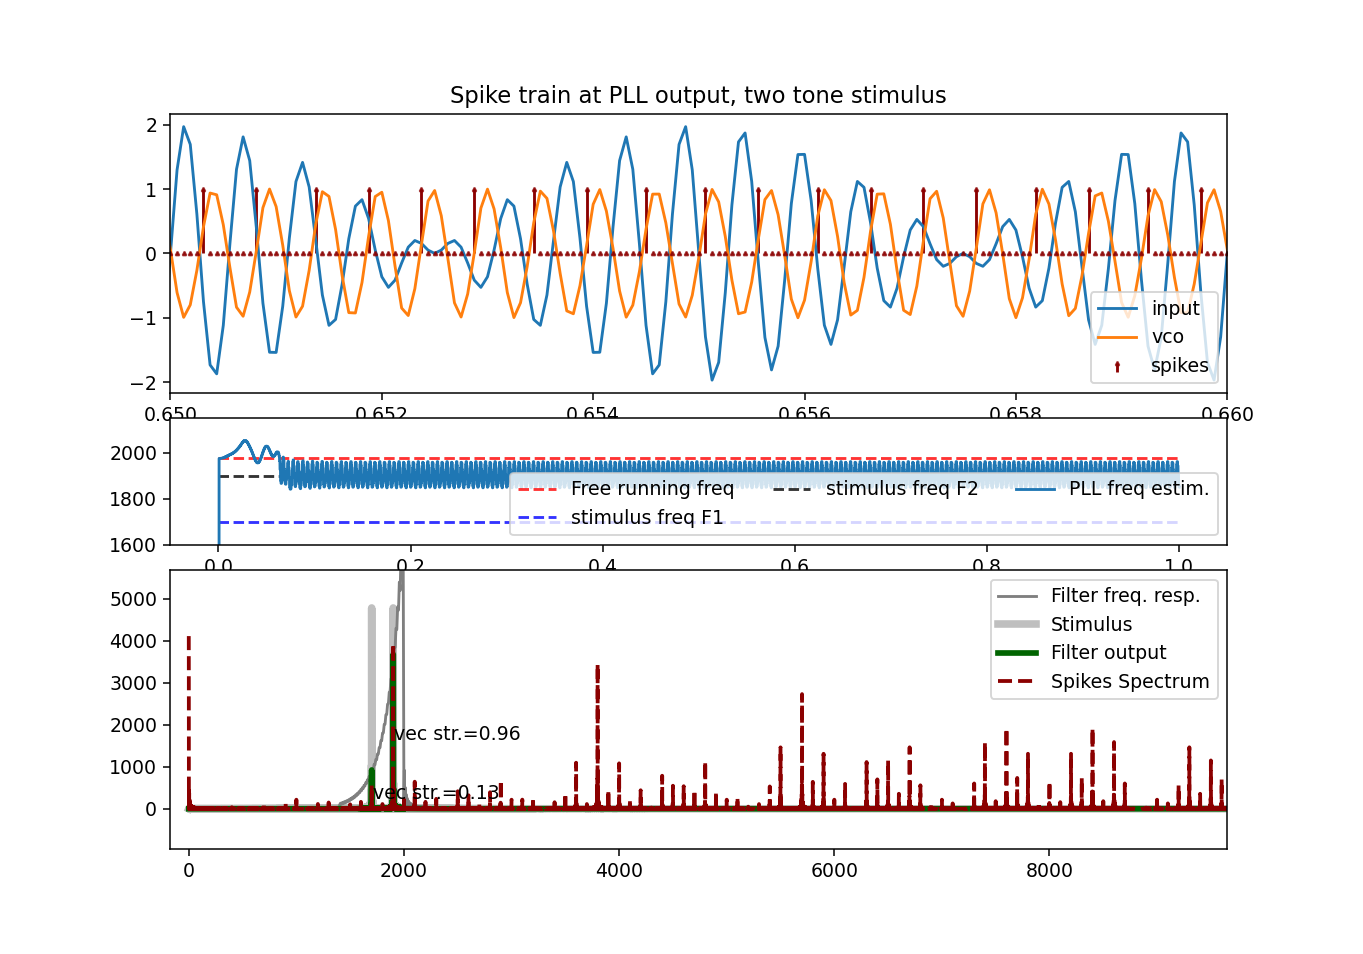

Text(0.5, 1.0, 'Spike train at PLL output, two tone stimulus')

In [24]:
# Two tone stimulus:
A = 1
f1 = 1700.
f2 = f1 + 200.
x1 = A * np.sin(2*pi*f1*t)
x2 = A * np.sin(2*pi*f2*t)

# Synchronic computation, filter and PLL as before.
y1 = sig.lfilter(hn,[1.],x1)
y2 = sig.lfilter(hn,[1.],x2)
y[0,:] = y1 + y2 
pll = sync.bank_pll(nplls = 1, ltime=ltime, sita=0.7, Fn=200., Fo=1975, fc_lock=4,Fs=Fs)
pll.section_calc(y)
# spikes train computation
pos = np.sign(pll.vco90[0,:])
tmp = sig.lfilter([0.5, -0.5],[1.],pos)
deltas = tmp*(np.sign(tmp)+1)/2.

#DFTs: only last one is necessary to compute vector strength; the others are for illustration goal.
In = np.fft.fft(x1+x2,8*len(deltas[t>=0.1]))
Out = np.fft.fft(y[0,:],8*len(deltas[t>=0.1]))
Del = np.fft.fft(deltas[t>=0.1],8*len(deltas[t>=0.1]))

Mi = np.max(np.abs(In))
Mo = np.max(np.abs(Out))
MH = np.max(np.abs(H_plot))
Md1 = np.max(np.abs(Del[(F>=(f1-1.)) & (F<=(f1+1))]))
Md2 = np.max(np.abs(Del[(F>=(f2-1.)) & (F<=(f2+1))]))
NN = (deltas[t>=0.1]**2).sum()


fig = plt.subplots(figsize=(10,7))
gridsize = (5,1)
ax0 = plt.subplot2grid(gridsize, (0, 0), colspan=1, rowspan=2)
ax1 = plt.subplot2grid(gridsize, (2, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid(gridsize, (3, 0), colspan=1, rowspan=2)


ax0.plot(t,1/A*(x1+x2))
ax0.plot(t,pll.vco90[0,:])
markerline,s,b = ax0.stem(t,deltas,linefmt ='darkred',basefmt='none',\
                      use_line_collection=True)
plt.setp(markerline,marker='^',color='darkred',markersize=2,alpha=0.8)

ax1.plot([t[0],t[-1]],[1975]*2,color='r',ls='--', alpha=0.8,label='Free running freq')
ax1.plot([t[0],t[-1]],[f1]*2,color='b',ls='--', alpha=0.8,label='stimulus freq F1')
ax1.plot([t[0],t[-1]],[f2]*2,color='k',ls='--', alpha=0.8,label='stimulus freq F2')
ax1.plot(t,pll.freq[0,:],label='PLL freq estim.')

# ax2.plot(t,pll.lock[0,:])
ax2.plot(fplot[(fplot>=1400) & (fplot<=2200)],np.abs(H_plot[(fplot>1400) & (fplot<=2200)])/MH*Mo*2.,\
    'k',alpha=0.5,label='Filter freq. resp.')
ax2.plot(F,np.abs(In)/Mi*Mo*1.3,lw = 4.,color=[0.5]*3,label='Stimulus',alpha=0.5)
ax2.plot(F,np.abs(Out),lw = 3.,color='darkgreen',label='Filter output')
ax2.plot(F,np.abs(Del)/Md*Mo,'--',lw = 2.,color='darkred',label='Spikes Spectrum')
tt1 = ax2.text(f1+10,Md1,'vec str.={:1.2f}'.format(Md1/NN))
tt2 = ax2.text(f2+10,Md2,'vec str.={:1.2f}'.format(Md2/NN))
plt.setp(tt1,ha='left')
plt.setp(tt2,ha='left')
ax0.set_xlim(65*0.01,66*0.01)
ax1.set_ylim(1600,2150)
ax2.set_xlim(1600,2150)
ax0.legend(('input','vco','spikes'))
ax1.legend(loc='lower right',ncol=3)
ax2.legend()
ax0.set_title('Spike train at PLL output, two tone stimulus')


In the first graph the two tone input signal is displayed with the VCO and spikes train. In the bottom graph, stimulus spectrum is depicted in gray gross line, showing equal amplitude at both frequency locations. This stimulus corresponds also to an amplitude modulated (AM) signal of central frequency $(F_1+F_2)/2$ and modulation frequency equal to $(F_2-F_1)$. 

Output filter spectrum is also displayed in the third graph in green line, showing a big attenuation at the $F_1$ frequeny. As a consecuence, $F_2$ signal is acquired at the PLL, as it is depicted in the middle graph. 

But if we zoom at the middle graph, it is possible to observe that frequency indication in this graph has an almost sinusoidal variation around $F_2$ frequency. This observation implies that VCO, and as a consecuence also the spikes train, posses a frequency modulated spectrum. The main frequency (carrier) is $F_2$, and main harmonics occur at $(F_2-F_1)$ distance from the carrier. The left first harmonic corresponds to $F_1$, that is indeed already present at the stimulus signal. But the right first harmonic, located at $F_2+(F_2-F_1) = 2F_2-F_1$ and almost the same amplitud, is a new byproduct and is not at the input stimulus. This kind of nonlinear behaviour is also observed at the biological experiments, puzzling for an explanation for the this new frequency. 

This frequency modulated spectrum can also explain the vector strength observations, where both vector strengths at $F_1$ and $F_2$ have more similar values between them. 

### The Two tones characteristic frequency experiment. 

The experiment consist on presenting two tones stimuli whose frequencies have equal separation between them, and avancing their frequencies from situations when vector strength is greather for the upper frequency until this situation is inverted. Central frequency where this change occures is considered as the CF2T.

In the following is depicted two of such situations, just before and after the change in vector strength occures. 

/home/ppelle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  # This is added back by InteractiveShellApp.init_path()


<IPython.core.display.Javascript object>


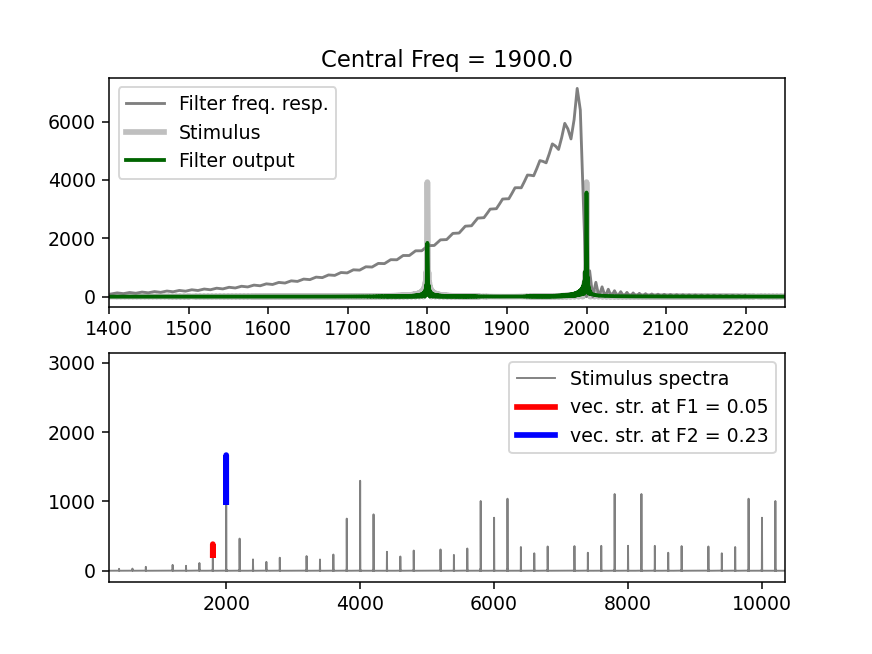

/home/ppelle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  # This is added back by InteractiveShellApp.init_path()


<IPython.core.display.Javascript object>


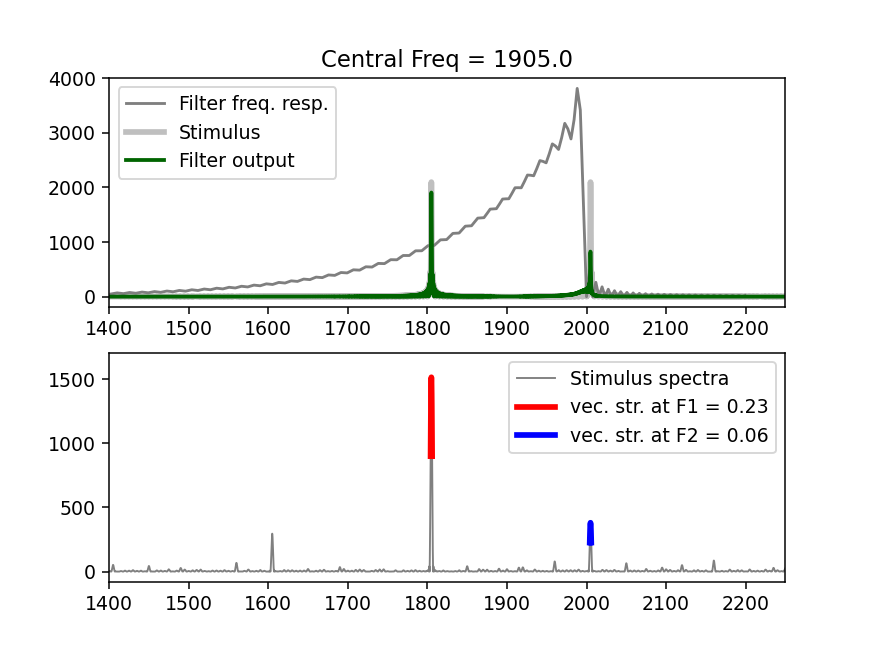

In [23]:
f1 = np.array([1800,1805.])
f2 = f1+200
A = 1 #Amplitude for both tones.

for k in range(len(f2)):

    x1 = A * np.sin(2*pi*f1[k]*t)
    x2 = A * np.sin(2*pi*f2[k]*t)
    y1 = sig.lfilter(hn,[1.],x1)
    y2 = sig.lfilter(hn,[1.],x2)
    y[0,:] = y1 + y2

    # PLL initialization
    pll = sync.bank_pll(nplls = 1, ltime=ltime, sita=0.7, Fn=200., Fo=1975, fc_lock=4,Fs=16000)
    pll.section_calc(y)

    pos = np.sign(np.sin(pll.vco90[0,:]))
    tmp = sig.lfilter([1., -1.],[1.],pos)
    
    deltas = tmp*(np.sign(tmp)+1)/2.
    
    In = np.fft.fft(x1+x2,8*len(deltas[t>=0.1]))
    Out = np.fft.fft(y[0,:],8*len(deltas[t>=0.1]))
    Del = np.fft.fft(deltas[t>=0.1]*np.hanning(len(deltas[t>=0.1])),8*len(deltas[t>=0.1]))

    Mi = np.max(np.abs(In))
    Mo = np.max(np.abs(Out))
    MH = np.max(np.abs(H_plot))

#     F = [0:length(indt)*8-1]/length(indt)*Fs/8;
    F = np.linspace(0,Fs,8*len(deltas[t>=0.1]),endpoint=False)
    Md1 = np.max(np.abs(Del[(F>=(f1[k]-1.)) & (F<=(f1[k]+1))]))
    Md2 = np.max(np.abs(Del[(F>=(f2[k]-1.)) & (F<=(f2[k]+1))]))
    NN = (deltas[t>=0.1]**2).sum()
    

    fig,ax = plt.subplots(2,1)
    ax[0].plot(fplot[(fplot>=1400) & (fplot<=2200)],np.abs(H_plot[(fplot>1400) & (fplot<=2200)])/MH*Mo*2.,\
        'k',alpha=0.5,label='Filter freq. resp.')

    ax[0].plot(F,np.abs(In)/Mi*Mo*1.1,lw = 3.,color=[0.5]*3,label='Stimulus',alpha=0.5)
    ax[0].plot(F,np.abs(Out),lw = 2.,color='darkgreen',label='Filter output'.format(f1[k]+100.))
    ax[0].legend()
    ax[0].set_title('Central Freq = {}'.format(f1[k]+100.))
    ax[1].plot(F,np.abs(Del),lw = 1.,color=[0.5]*3,label='Stimulus spectra')
    ax[1].plot(F[(F>=(f1[k]-1.)) & (F<=(f1[k]+1))],np.abs(Del[(F>=(f1[k]-1.)) & (F<=(f1[k]+1))]),'-r',lw=3\
              ,label='vec. str. at F1 = {:1.2f}'.format(Md1/NN))
    ax[1].plot(F[(F>=(f2[k]-1.)) & (F<=(f2[k]+1))],np.abs(Del[(F>=(f2[k]-1.)) & (F<=(f2[k]+1))]),'-b',lw=3\
              ,label='vec. str. at F2 = {:1.2f}'.format(Md2/NN))
    ax[1].legend()

    ax[0].set_xlim(1400,2250)
    ax[1].set_xlim(1400,2250)


In these cases, the spectrum at the PLL input is showing two tones of important amplitude. As a consecuence, modulated frequency effect is deep, and harmonics have greather amplitude than in the previous situation. Also a lot of harmonics has a considerable amplitude, as can be seen by zooming out the figure. In this case, CF2T is somewhere between these two central frequencies. 

The last code block describes the complete CF2T experiment. 

<IPython.core.display.Javascript object>


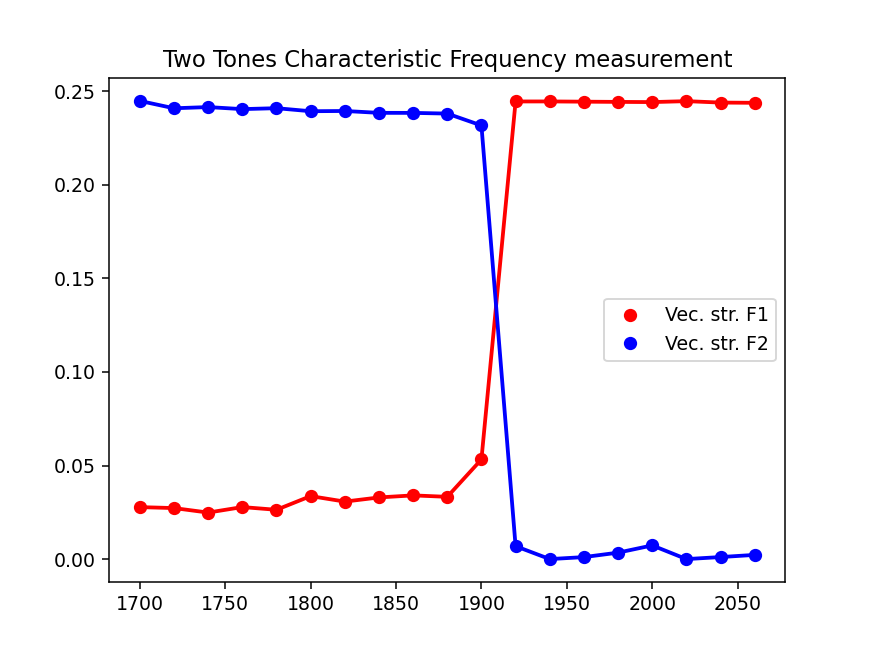

freq = 1800.0


/home/ppelle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()


freq = 1820.0
freq = 1840.0
freq = 1860.0
freq = 1880.0
freq = 1900.0
freq = 1920.0
freq = 1940.0
freq = 1960.0
freq = 1980.0
freq = 2000.0
freq = 2020.0
freq = 2040.0
freq = 2060.0
freq = 2080.0
freq = 2100.0
freq = 2120.0
freq = 2140.0
freq = 2160.0


In [22]:
# print(f1[0],f1[10])
fig,ax = plt.subplots()
fig.canvas.draw()
plt.show(block=False)

f1 = np.arange(1600,1970,20)
f2 = f1 + 200.
vecstr = np.empty((2,len(f1)))

for k in range(len(f1)):
    print('freq = {}'.format(f2[k]))
    x1 = A * np.sin(2*pi*f1[k]*t);
    x2 = A * np.sin(2*pi*f2[k]*t);
    y1 = sig.lfilter(hn,[1.],x1);
    y2 = sig.lfilter(hn,[1.],x2);
    y[0,:] = y1 + y2

    # PLL initialization
    pll = sync.bank_pll(nplls = 1, ltime=ltime, sita=0.7, Fn=200., Fo=1975, fc_lock=4,Fs=16000)
    pll.section_calc(y)

    pos = np.sign(np.sin(pll.vco90[0,:]))
    tmp = sig.lfilter([1., -1.],[1.],pos)
    deltas = tmp*(np.sign(tmp)+1)/2.
    
    Del = np.fft.fft(deltas[t>=0.1]*np.hanning(len(deltas[t>=0.1])),8*len(deltas[t>=0.1]))
    F = np.linspace(0,Fs,8*len(deltas[t>=0.1]),endpoint=False)
    Md1 = np.max(np.abs(Del[(F>=(f1[k]-1.)) & (F<=(f1[k]+1))]))
    Md2 = np.max(np.abs(Del[(F>=(f2[k]-1.)) & (F<=(f2[k]+1))]))
    NN = (deltas[t>=0.1]**2).sum()

    vecstr[0,k] = Md1/NN
    vecstr[1,k] = Md2/NN
    ax.plot(f1[k]+100,vecstr[0,k],'or',lw=2,markerfacecolor='r',label='Vec. str. F1' if k==0 else '_nolabel_')
    ax.plot(f1[k]+100,vecstr[1,k],'ob',lw=2,markerfacecolor='b',label='Vec. str. F2' if k==0 else '_nolabel_')

    ax.relim() 
    ax.autoscale_view(True,True,True) 
    fig.canvas.draw()

    
#     ax[1].plot(F,np.abs(Del),lw = 1.,color=[0.5]*3,label='freq={}'.format(f1[k]+100.))
#     ax[1].plot(F[(F>=(f1[k]-1.)) & (F<=(f1[k]+1))],np.abs(Del[(F>=(f1[k]-1.)) & (F<=(f1[k]+1))]),lw=3)
#     ax[2].plot(F,np.abs(Del),lw = 1.,color=[0.5]*3,label='freq={}'.format(f1[k]+100.))
#     ax[2].plot(F[(F>=(f2[k]-1.)) & (F<=(f2[k]+1))],np.abs(Del[(F>=(f2[k]-1.)) & (F<=(f2[k]+1))]),lw=3)
    

# ax[0].set_ylim(1400,2100)
# ax[1].set_xlim(1400,2200)
# ax[2].set_xlim(1400,2200)
ax.legend()
ax.set_title('Two Tones Characteristic Frequency measurement')
ax.plot(f1+100.,vecstr[0,:],'r',lw=2)
ax.plot(f1+100.,vecstr[1,:],'b',lw=2)